# LioJotstar Merger: Data Analysis with Python for Strategic Optimization

## 8. Upgrade Patterns: Who’s Moving Up and Why?
This notebook visualizes user downgrade behavior on LioCinema and Jotstar. It uses combined grouped bar and line charts to show monthly downgrade volumes and rates, population pyramids to display the age distribution of downgraders, stacked bar charts for city tier distribution of downgraders, pie charts to illustrate the different downgrade paths within each platform, and line charts to compare monthly upgrade and downgrade rates.

### Importing Required Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Required DataFrames from Saved Parquet Files

In [6]:
try:
    jotstar_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/Jotstar_db/subscribers.parquet')
    print("Jotstar - Subscribers table loaded successfully.")
    liocinema_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/LioCinema_db/subscribers.parquet')
    print("LioCinema - Subscribers table loaded successfully.")
    print("\nData Loading Complete.")
    
except FileNotFoundError as e:
       print("Error: One or more Parquet files not found. Please check the file paths.")
       print(f"Details: {e}")
except Exception as e:
       print("An error occurred during data import.")
       print(f"Details: {e}")

Jotstar - Subscribers table loaded successfully.
LioCinema - Subscribers table loaded successfully.

Data Loading Complete.


### Data Analysis & Visualization

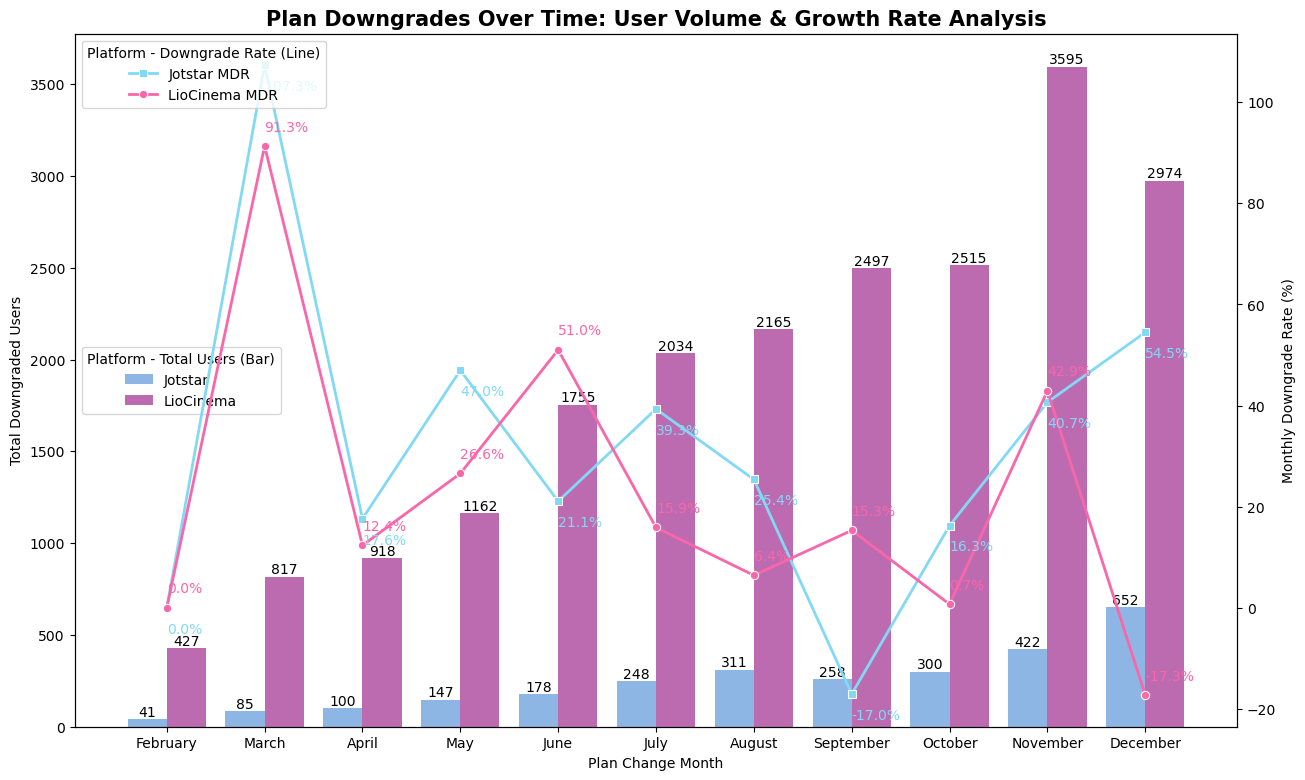

In [8]:
def get_downgraded_user_count(df):
    temp_df = df[['User ID', 'Plan Change Date', 'Plan Change Type']].copy()
    temp_df['Plan Change Month Number'] = temp_df['Plan Change Date'].dt.month
    temp_df['Plan Change Month'] = temp_df['Plan Change Date'].dt.month_name()
    result = temp_df.groupby(['Plan Change Month Number', 'Plan Change Month', 'Plan Change Type'])['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID': 'Total Downgraded Users'})
    # Calculate Monthly Downgrade Rate
    result['Monthly Downgrade Rate (%)'] = round(result['Total Downgraded Users'].pct_change() * 100, 2)
    result['Monthly Downgrade Rate (%)'] = result['Monthly Downgrade Rate (%)'].fillna(0)
    return result
    
jotstar_temp_df = get_downgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Downgrade"])
liocinema_temp_df = get_downgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Downgrade"])
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])
merged_df = merged_df.reset_index()
merged_df = merged_df.sort_index()

fig, ax1 = plt.subplots(figsize = (15, 9))
ax2 = ax1.twinx()

bp = sns.barplot(x = 'Plan Change Month', y = 'Total Downgraded Users', data = merged_df, hue = 'Platform', palette = ["#7FB5F4", "#CB5DBB"], 
                 ax = ax1)
for i in bp.containers:
    bp.bar_label(i)

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Downgrade Rate (%)', data = merged_df[merged_df['Platform'] == "Jotstar"], 
             color = "#82D9F5", marker = "s", linewidth = 2, ax = ax2, label = "Jotstar MDR")
for a, b, platform in zip(merged_df['Plan Change Month'], merged_df['Monthly Downgrade Rate (%)'], merged_df['Platform']):
    if platform == "Jotstar": 
        plt.text(x = a, y = b - 5, s = f"{b:.1f}%", color = "#82D9F5")

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Downgrade Rate (%)', data = merged_df[merged_df['Platform'] == "LioCinema"], 
             color = "#F966AA", marker = "o", linewidth = 2, ax = ax2, label = "LioCinema MDR")
for a, b, platform in zip(merged_df['Plan Change Month'], merged_df['Monthly Downgrade Rate (%)'], merged_df['Platform']):
    if platform == "LioCinema": 
        plt.text(x = a, y = b + 3, s = f"{b:.1f}%", color = "#F966AA")

plt.title("Plan Downgrades Over Time: User Volume & Growth Rate Analysis", fontsize = 15, fontweight = "bold")
ax1.grid(False)
ax2.grid(False)
ax1.legend(title = "Platform - Total Users (Bar)", loc = "center left")
ax2.legend(title = "Platform - Downgrade Rate (Line)", loc = "upper left")

# Saving multi-row KPI to Excel for Tabular viewing
merged_df.to_excel('KPIs Excel Files/Monthly Downgrade Rate.xlsx')

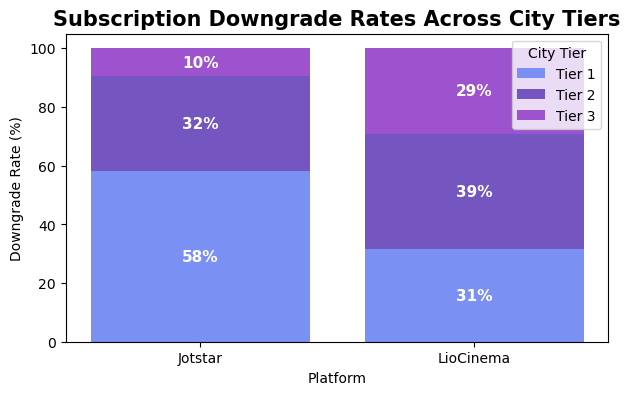

In [10]:
def get_downgraded_user_count(df):
    result = df.groupby('City Tier')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Downgraded Users'}).reset_index()
    total_downgraded_users = sum(result['Total Downgraded Users'])
    result['Downgrade Rate (%)'] = ((result['Total Downgraded Users'] / total_downgraded_users) * 100)
    return result
    
jotstar_temp_df = get_downgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Downgrade"])
liocinema_temp_df = get_downgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Downgrade"])
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

pivot_df = merged_df.pivot(index = 'Platform', columns = 'City Tier', values = ['Downgrade Rate (%)']).fillna(0)

total_downgrade_rate = pivot_df['Downgrade Rate (%)']

fig, ax = plt.subplots(figsize = (7, 4))

bars_tier1 = ax.bar(total_downgrade_rate.index, total_downgrade_rate.get("Tier 1", 0), color = "#7B90F3", label = "Tier 1")

bars_tier2 = ax.bar(total_downgrade_rate.index, total_downgrade_rate.get("Tier 2", 0), 
                 bottom = total_downgrade_rate.get("Tier 1", 0), color = "#7555BF", 
                    label = "Tier 2")

bars_tier3 = ax.bar(total_downgrade_rate.index, total_downgrade_rate.get("Tier 3", 0), 
                   bottom = total_downgrade_rate.get("Tier 1", 0) + total_downgrade_rate.get("Tier 2", 0), 
                   color = "#9C53CD", label = "Tier 3")

for bars in [bars_tier1, bars_tier2, bars_tier3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,  
                    f"{height:.0f}%",  
                    ha = "center", va = "center", color = "white", fontsize = 11, fontweight = "bold")

ax.set_xlabel("Platform")
ax.set_ylabel("Downgrade Rate (%)")
ax.set_title("Subscription Downgrade Rates Across City Tiers", fontsize = 15, fontweight = "bold")
ax.legend(title = "City Tier", loc = "best")

([<matplotlib.patches.Wedge at 0x2408c0d16a0>,
 [Text(0.019962375766550553, 1.0998188503357065, 'Basic → Free'),
  Text(-0.5144819485287448, -0.9722696769096865, 'Premium → Free'),
  Text(0.9814461587968816, -0.4967528936834152, 'Premium → Basic')],
 [Text(0.010888568599936664, 0.5999011910922034, '49.4%'),
  Text(-0.2806265173793154, -0.5303289146780107, '35.7%'),
  Text(0.5353342684346626, -0.2709561238273173, '14.9%')])

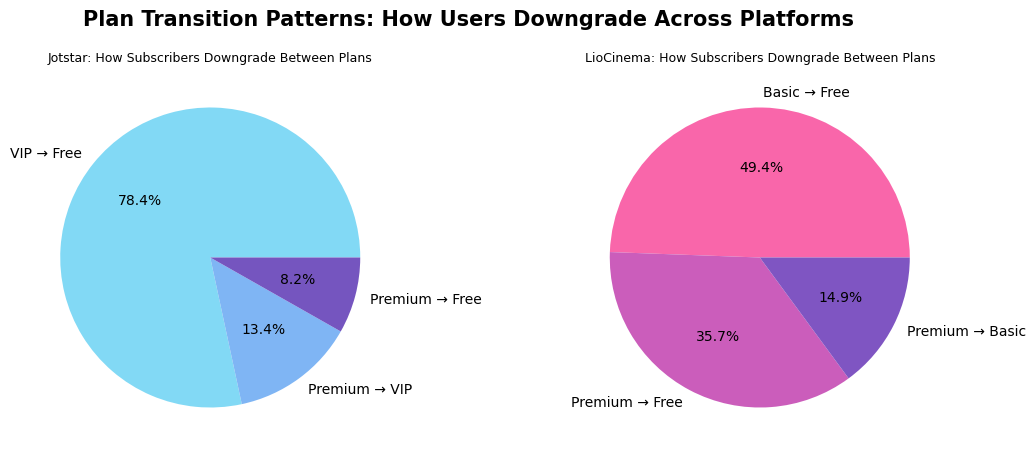

In [11]:
def get_downgraded_user_count(df):
    result = df.groupby('Plan Transition')['User ID'].count()
    result = result.to_frame().rename(columns = {'User ID':'Total Downgraded Users'}).reset_index()
    result = result.sort_values('Total Downgraded Users', ascending = False)
    return result
    
jotstar_temp_df = get_downgraded_user_count(jotstar_subscribers_df[jotstar_subscribers_df['Plan Change Type'] == "Downgrade"])
liocinema_temp_df = get_downgraded_user_count(liocinema_subscribers_df[liocinema_subscribers_df['Plan Change Type'] == "Downgrade"])

plt.figure(figsize = (13, 5))
plt.subplots_adjust(top = 0.86)
plt.suptitle("Plan Transition Patterns: How Users Downgrade Across Platforms", fontsize = 15, fontweight = "bold")

Jotstar = ["#82D9F5", "#7FB5F4", "#7555BF"]
LioCinema = ["#F966AA", "#CB5DBB", "#7F55C2"]

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
plt.title("Jotstar: How Subscribers Downgrade Between Plans", fontsize = 9)
plt.pie(jotstar_temp_df['Total Downgraded Users'], labels = jotstar_temp_df['Plan Transition'], autopct='%1.1f%%', colors = Jotstar)

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
plt.title("LioCinema: How Subscribers Downgrade Between Plans", fontsize = 9)
plt.pie(liocinema_temp_df['Total Downgraded Users'], labels = liocinema_temp_df['Plan Transition'], autopct='%1.1f%%', colors = LioCinema)

,Platform,Plan Change Month,Total Upgraded Users,Total Downgraded Users,Monthly Upgrade vs. Downgrade Rate (%)
0,Jotstar,February,235,41,573.17
1,Jotstar,March,386,85,454.12
2,Jotstar,April,437,100,437.00
3,Jotstar,May,449,147,305.44
4,Jotstar,June,437,178,245.51
5,Jotstar,July,413,248,166.53
6,Jotstar,August,439,311,141.16
7,Jotstar,September,373,258,144.57
8,Jotstar,October,381,300,127.00
9,Jotstar,November,494,422,117.06


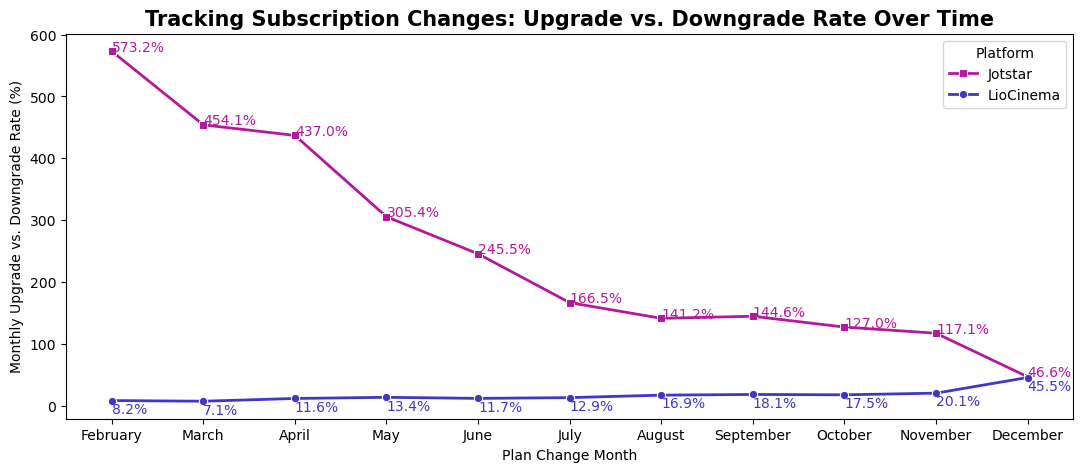

In [12]:
def get_upgrade_vs_downgrade_rate(df):
    temp_df = df[['User ID', 'Plan Change Date', 'Plan Change Type']].copy()
    temp_df['Plan Change Month Number'] = temp_df['Plan Change Date'].dt.month
    temp_df['Plan Change Month'] = temp_df['Plan Change Date'].dt.month_name()
    result = temp_df.groupby(['Plan Change Month Number', 'Plan Change Month', 'Plan Change Type'])['User ID'].count().unstack(fill_value = 0)
    result['Total Upgraded Users'] = result.get('Upgrade', 0)
    result['Total Downgraded Users'] = result.get('Downgrade', 0)
    result['Monthly Upgrade vs. Downgrade Rate (%)'] = round(((result['Total Upgraded Users'] / result['Total Downgraded Users']).replace(
        [float('inf'), float('-inf')], None) * 100), 2)
    return result.reset_index()
    
jotstar_temp_df = get_upgrade_vs_downgrade_rate(jotstar_subscribers_df)
liocinema_temp_df = get_upgrade_vs_downgrade_rate(liocinema_subscribers_df)

plt.subplots(figsize = (13, 5)) 

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Upgrade vs. Downgrade Rate (%)', data = jotstar_temp_df, color = "#B5179E", 
             marker = "s", linewidth = 2, label = "Jotstar")
for a, b in zip(jotstar_temp_df['Plan Change Month'], jotstar_temp_df['Monthly Upgrade vs. Downgrade Rate (%)']):
        plt.text(x = a, y = b, s = f"{b:.1f}%", color = "#B5179E")

sns.lineplot(x = 'Plan Change Month', y = 'Monthly Upgrade vs. Downgrade Rate (%)', data = liocinema_temp_df, color = "#3F37C9", 
             marker = "o", linewidth = 2, label = "LioCinema")
for a, b in zip(liocinema_temp_df['Plan Change Month'], liocinema_temp_df['Monthly Upgrade vs. Downgrade Rate (%)']):
        plt.text(x = a, y = b - 20.5, s = f"{b:.1f}%", color = "#3F37C9")

plt.title("Tracking Subscription Changes: Upgrade vs. Downgrade Rate Over Time", fontsize = 15, fontweight = "bold")
plt.legend(title = "Platform", loc = "best")

jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

# Saving multi-row KPI to Excel for Tabular viewing
merged_df.to_excel('KPIs Excel Files/Monthly Upgrade vs. Downgrade Rate.xlsx')

print_result_df = merged_df[['Platform', 'Plan Change Month', 'Total Upgraded Users', 'Total Downgraded Users', 
                             'Monthly Upgrade vs. Downgrade Rate (%)']].copy()
print_result_df = print_result_df.reset_index(drop = True).rename_axis(None, axis = 1)
print_result_df

## Next Notebook: "10. Streaming Insights: Watch Time, Devices & User Segments"